In [5]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import numpy as np
import csv
import matplotlib.pyplot as plt

from tqdm import tqdm
import wandb

# Data

In [ ]:
dataset_path = 'data/images'
annotations_file = 'data/annotations.csv'

## train/validation/test split

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

annotations_df = pd.read_csv(annotations_file)

# Получаем список уникальных изображений
image_ids = annotations_df["image_id"].unique()

# Разбиваем на train (80%), test (10%), val (10%)
train_ids, test_ids = train_test_split(image_ids, test_size=0.4, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

Train: 21021, Val: 7007, Test: 7008


## dataset

In [7]:
class DetectionDataset(Dataset):
    def __init__(self, annotations_file, images_dir, image_ids, transform=None):
        self.annotations_csv = annotations_file
        self.images_dir = images_dir
        self.image_ids = set(image_ids)  # Ограничиваем датасет только этими изображениями
        self.transform = transform

        # Загружаем аннотации из CSV
        self.image_annotations = self.load_annotations()

    def load_annotations(self):
        annotations = {}
        with open(self.annotations_csv, "r") as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                image_id = row[0]
                if image_id not in self.image_ids:  # Добавляем только те, что в разбиении
                    continue
                x_min, y_min, width, height = map(int, row[1:5])
                class_id = int(row[5])

                if image_id not in annotations:
                    annotations[image_id] = []
                annotations[image_id].append([x_min, y_min, x_min + width, y_min + height, class_id])
        return annotations

    def __len__(self):
        return len(self.image_annotations)

    def __getitem__(self, idx):
        image_id = list(self.image_annotations.keys())[idx]
        image_path = os.path.join(self.images_dir, image_id)

        try:
          image = cv2.imread(image_path)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
          print(f"Error loading image {image_path}: {e}")
          return None

        annotations = self.image_annotations[image_id]
        labels = np.array([ann[4] for ann in annotations])
        bboxes = np.array([ann[:4] for ann in annotations])

        # Убираем "пустые" боксы
        valid_indices = ~(np.all(bboxes == 0, axis=1))
        if np.any(valid_indices):
            bboxes = bboxes[valid_indices]
            labels = labels[valid_indices]
        else:
            bboxes = np.array([[0, 0, 1, 1]])  # Фиктивный бокс, чтобы Albumentations не сломался
            labels = np.array([0])

        # Применяем аугментации
        if self.transform:
            augmented = self.transform(image=image, bboxes=bboxes, labels=labels)
            image = augmented['image']
            bboxes = torch.tensor(augmented['bboxes'], dtype=torch.float32)
            labels = torch.tensor(augmented['labels'], dtype=torch.long)

        return image, bboxes, labels

In [8]:
train_transform = A.Compose([
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'],
                            check_each_transform=True, min_visibility=0.1))


test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class FaceDetectionModel(nn.Module):
    def __init__(self):
        super(FaceDetectionModel, self).__init__()

        backbone = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        self.feature_extractor = backbone.features

        # Регрессия (bounding box)
        self.regression_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(960, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 4)  # 4 выхода - координаты бокса
        )

        # Классификация
        self.classifier_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(960, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 1)  # Один выход для бинарной классификации
        )

    def forward(self, x):
        features = self.feature_extractor(x)

        # Получаем координаты бокса
        bbox = self.regression_head(features)

        # Получаем предсказания для классификации
        classification = self.classifier_head(features)

        return classification, bbox

# Loss & metrics

In [ ]:
# Функция потерь для классификации
def loss_fn_classification(preds_class, targets_class):
    return nn.BCEWithLogitsLoss()(preds_class.squeeze(1), targets_class.float())

# Функция потерь для регрессии (учитываем только валидные боксы)
def loss_fn_regression(preds_bbox, targets_bbox):
    return nn.SmoothL1Loss()(preds_bbox, targets_bbox)

# Итоговая функция потерь с учетом классов
def total_loss_fn(preds_class, targets_class, preds_bbox, targets_bbox):
    # Маска: выбираем только примеры, где класс НЕ 0 (то есть, где есть человек)
    valid_bboxes_mask = (targets_class > 0)

    # Потери для классификации считаем для всех примеров
    class_loss = loss_fn_classification(preds_class, targets_class)

    # Потери для регрессии только для валидных боксов
    if valid_bboxes_mask.any():
        bbox_loss = loss_fn_regression(preds_bbox[valid_bboxes_mask], targets_bbox[valid_bboxes_mask])
    else:
        bbox_loss = torch.tensor(0.0, device=preds_bbox.device)  # Если нет валидных боксов, ставим 0

    # Общая функция потерь
    total_loss = class_loss + bbox_loss
    return total_loss

In [ ]:
def intersection_over_union(preds_bbox, target_bbox):
    """
    Функция для вычисления IoU между предсказанными и истинными боксов.

    Parameters:
    preds_bbox (torch.Tensor): Тензор с предсказанными боксами (batch_size x 4)
    target_bbox (torch.Tensor): Тензор с истинными боксами (batch_size x 4)

    Returns:
    torch.Tensor: Тензор с IoU для каждого примера в батче.
    """
    # Преобразуем координаты в (x1, y1, x2, y2)
    x1_pred, y1_pred, x2_pred, y2_pred = preds_bbox.split(1, dim=-1)
    x1_true, y1_true, x2_true, y2_true = target_bbox.split(1, dim=-1)

    # Вычисляем координаты пересечения
    x1_inter = torch.max(x1_pred, x1_true)
    y1_inter = torch.max(y1_pred, y1_true)
    x2_inter = torch.min(x2_pred, x2_true)
    y2_inter = torch.min(y2_pred, y2_true)

    # Вычисляем площадь пересечения
    inter_area = torch.clamp(x2_inter - x1_inter, min=0) * torch.clamp(y2_inter - y1_inter, min=0)

    # Вычисляем площадь каждого бокса
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    true_area = (x2_true - x1_true) * (y2_true - y1_true)

    # Вычисляем объединенную площадь
    union_area = pred_area + true_area - inter_area

    # Вычисляем IoU
    iou = inter_area / torch.clamp(union_area, min=1e-6)
    return iou

# DataLoader

In [9]:
train_dataset = DetectionDataset(annotations_file, dataset_path, train_ids, transform=train_transform)
val_dataset = DetectionDataset(annotations_file, dataset_path, val_ids, transform=test_transform)
test_dataset = DetectionDataset(annotations_file, dataset_path, test_ids, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Посмотрим на данные

In [10]:
def visualize_samples(dataset, num_samples=8, figsize=(20, 10)):
    length = len(dataset)
    indexes = np.random.choice(range(length), size=num_samples, replace=False)

    items = [dataset[index] for index in indexes]
    rows, cols = 2, num_samples // 2
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

    for idx, (image, bboxes, label) in enumerate(items):
        row, col = divmod(idx, cols)  # Разбиение индекса на строку и столбец

        image = image.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
        normalized_image = np.clip((image - image.min()) / (image.max() - image.min()), 0, 1)  # Коррекция для imshow

        # Рисуем bounding box
        for bbox in bboxes:
            if len(bbox) == 4:  # Убеждаемся, что bbox корректный
                x_min, y_min, x_max, y_max = map(int, bbox)
                cv2.rectangle(normalized_image, (x_min, y_min), (x_max, y_max), color=(1, 0, 0), thickness=2)

        ax[row, col].imshow(normalized_image)
        ax[row, col].axis("off")

    plt.tight_layout()
    plt.show()

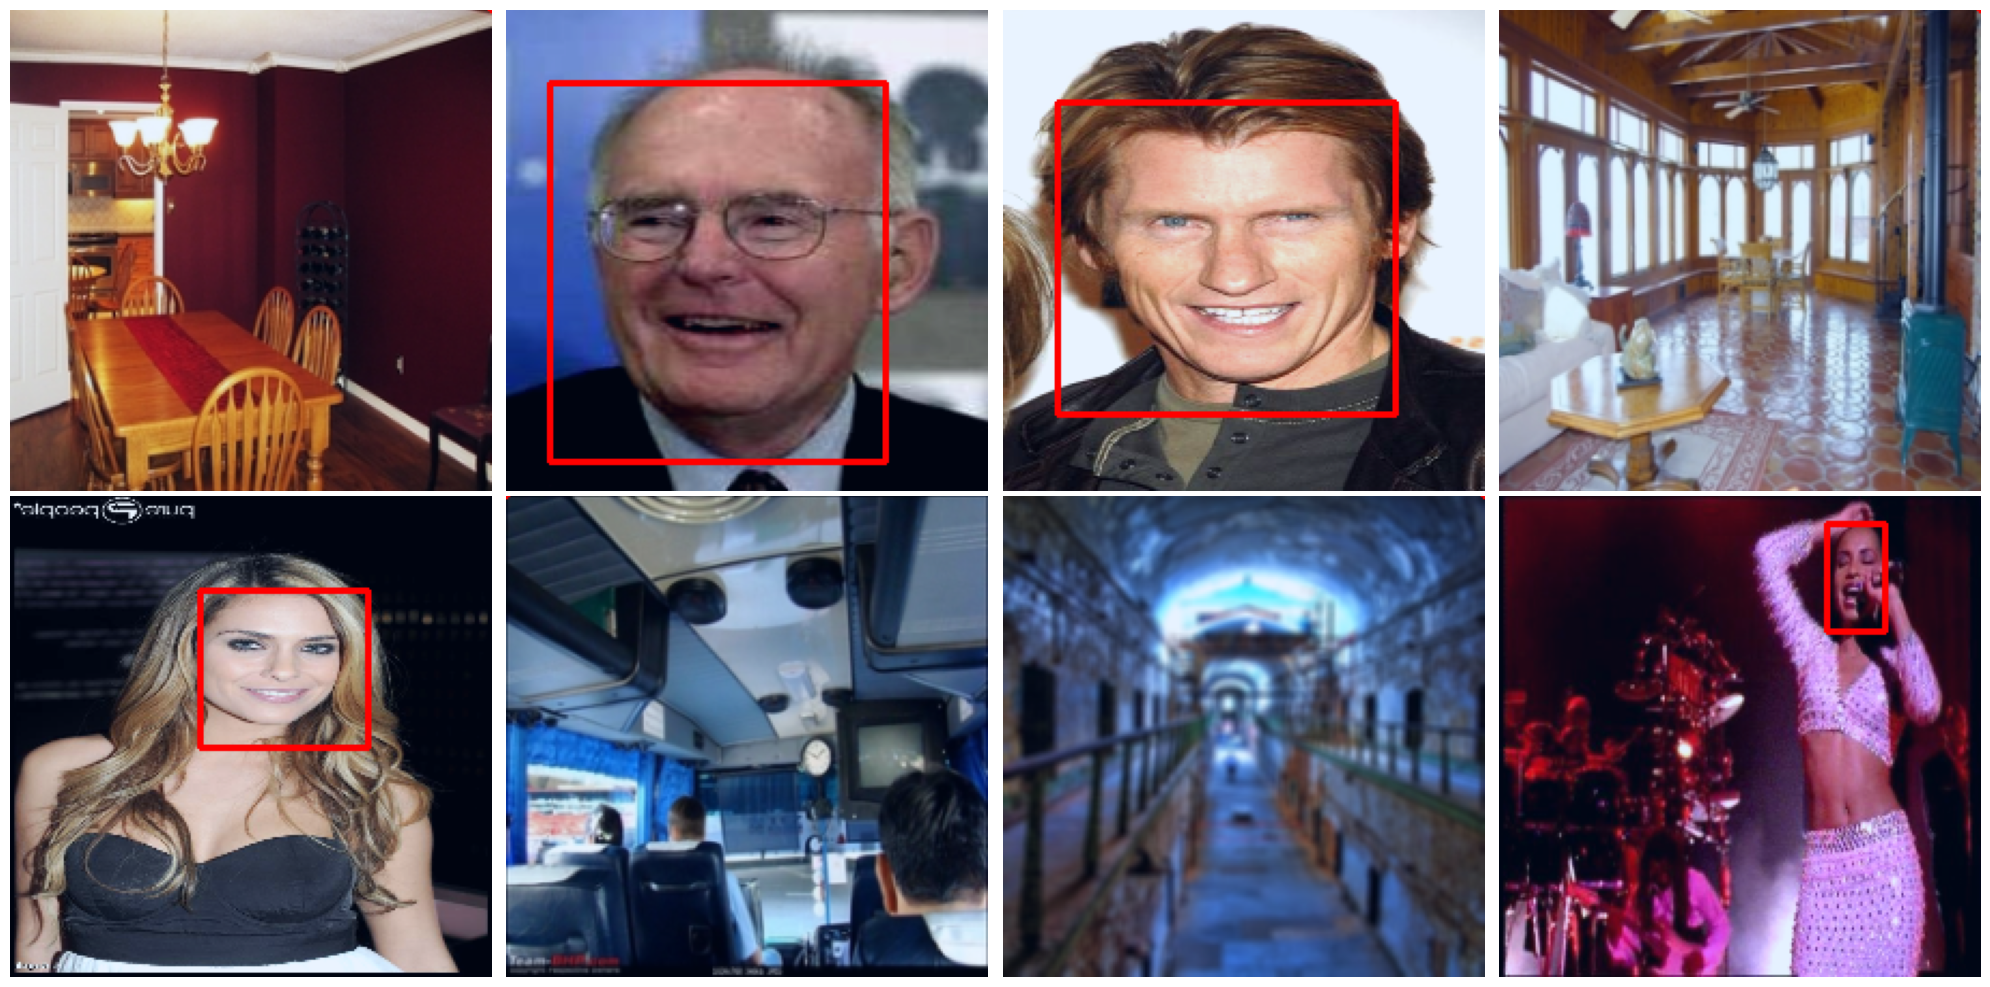

In [11]:
visualize_samples(train_dataset)

# Train

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Single epoch learning function

In [ ]:
def train_one_epoch(model, dataloader, optimizer, device):
  model.train()
  total_loss = 0
  iou_scores, all_preds, all_targets = [], [], []
  for images, bboxes, labels in tqdm(dataloader, desc="Training"):
    images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)

    bboxes = bboxes.squeeze(1)
    labels = labels.squeeze(1)

    optimizer.zero_grad()
    preds_class, preds_bbox = model(images)

    loss = total_loss_fn(preds_class, labels, preds_bbox, bboxes)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    iou_scores.append(intersection_over_union(preds_bbox, bboxes))
    all_preds.extend(torch.sigmoid(preds_class).detach().cpu().numpy() > 0.5)
    all_targets.extend(labels.detach().cpu().numpy())


  avg_iou = torch.cat(iou_scores).mean().item()
  accuracy = accuracy_score(all_targets, all_preds)
  precision = precision_score(all_targets, all_preds)
  recall = recall_score(all_targets, all_preds)
  f1 = f1_score(all_targets, all_preds)

  # Логируем в W&B
  wandb.log({
      "Train loss": total_loss / len(dataloader),
      "Train IoU": avg_iou,
      "Train Accuracy": accuracy,
      "Train Precision": precision,
      "Train Recall": recall,
      "Train F1-score": f1,
  })

  return total_loss / len(dataloader)

## Eval

In [ ]:
def evaluate(model, dataloader, device):
  model.eval()
  total_loss = 0
  iou_scores, all_preds, all_targets = [], [], []

  with torch.no_grad():
    for images, bboxes, labels in tqdm(dataloader, desc="Evaluating"):
      images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)

      bboxes = bboxes.squeeze(1)
      labels = labels.squeeze(1)
      preds_class, preds_bbox = model(images)

      loss = total_loss_fn(preds_class, labels, preds_bbox, bboxes)
      total_loss += loss.item()

      iou_scores.append(intersection_over_union(preds_bbox, bboxes))
      all_preds.extend(torch.sigmoid(preds_class).detach().cpu().numpy() > 0.5)  # .detach() добавлено
      all_targets.extend(labels.detach().cpu().numpy())  # .detach() добавлено


    avg_iou = torch.cat(iou_scores).mean().item()
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    # Логируем в W&B
    wandb.log({
        "Val Loss": total_loss / len(dataloader),
        "Val IoU": avg_iou,
        "Val Accuracy": accuracy,
        "Val Precision": precision,
        "Val Recall": recall,
        "Val F1-score": f1,
    })

    return total_loss / len(dataloader), avg_iou, accuracy, precision, recall, f1

## Learning across all epochs

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, device):
  model.to(device)

  for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    # Обучение
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}")

    # Валидация
    val_loss, avg_iou, acc, prec, rec, f1 = evaluate(model, val_loader, device)
    print(f"Val Loss: {val_loss:.4f}, IoU: {avg_iou:.4f}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    save_model(model, optimizer, epoch, train_loss)

  wandb.finish()

## save checkpoints

In [ ]:
def save_model(model, optimizer, epoch, loss, filename="model_checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Model checkpoint saved at epoch {epoch}")

def load_model(model, optimizer, filename="model_checkpoint.pth"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Model loaded from epoch {epoch} with loss {loss}")
    return model, optimizer, epoch, loss

# Training!

In [ ]:
from tqdm import tqdm
import wandb

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceDetectionModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
wandb.login(key='write your wandb key')
wandb.init(project='', name='')

In [ ]:
train_model(model, train_loader, val_loader, optimizer, num_epochs=15, device=device)

In [ ]:
torch.save(model.state_dict(), "detector_weights.pth")